# GroupfMRI14a - Evaluate hidden-layer representations, compare activity flow predictions/actual/ANN hidden features


#### Takuya Ito
#### 10/27/2019

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing as mp
import scipy.stats as stats
import os
os.environ['OMP_NUM_THREADS'] = str(1)
import statsmodels.sandbox.stats.multicomp as mc
import seaborn as sns
import h5py
import tools_group_rsa as tools_group
import nibabel as nib
import EmpiricalSRActFlow_ANN_RSA_v2 as esr
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "FreeSans"
import pandas as pd
import time
import analysis_representationTransform as analysis


In [5]:
# Excluding 084
subjNums = ['013','014','016','017','018','021','023','024','026','027','028','030','031','032','033',
            '034','035','037','038','039','040','041','042','043','045','046','047','048','049','050',
            '053','055','056','057','058','062','063','066','067','068','069','070','072','074','075',
            '076','077','081','085','086','087','088','090','092','093','094','095','097','098','099',
            '101','102','103','104','105','106','108','109','110','111','112','114','115','117','119',
            '120','121','122','123','124','125','126','127','128','129','130','131','132','134','135',
            '136','137','138','139','140','141']



basedir = '/projects3/SRActFlow/'

# Using final partition
networkdef = np.loadtxt('/projects3/NetworkDiversity/data/network_partition.txt')
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
networkorder.shape = (len(networkorder),1)
# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()

xticks = {}
reorderednetworkaffil = networkdef[networkorder]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

## General parameters/variables
nParcels = 360
nSubjs = len(subjNums)

glasserfile2 = '/projects/AnalysisTools/ParcelsGlasser2016/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser2 = nib.load(glasserfile2).get_data()
glasser2 = np.squeeze(glasser2)

sortednets = np.sort(xticks.keys())
orderednetworks = []
for net in sortednets: orderednetworks.append(xticks[net])
    
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)

OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']

# Load activations for actual hidden layer (non-activity flow predicted)

In [110]:
# gsr = True
n_features = 28 # 12 rules, 16 stim combos
data_task = np.zeros((len(glasser2),n_features,len(subjNums)))
rules = ['Logic','Sensory','Motor']
stimuli = ['colorStim','oriStim','pitchStim','constantStim']


scount = 0
for subj in subjNums:
    print('Loading subject', subj)
    indstart = 0
    indend = 4
    for rule in rules:
        data_task[:,indstart:indend,scount] = tools_group.loadRuleEncoding(subj,rule)
        indstart += 4
        indend += 4
    
    for stim in stimuli:
        data_task[:,indstart:indend,scount] = tools_group.loadInputActivity(subj,stim)
        indstart += 4
        indend += 4
    
    scount += 1


('Loading subject', '013')


/home/usr/local/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
/home/usr/local/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:19: ComplexWarning: Casting complex values to real discards the imaginary part


('Loading subject', '014')
('Loading subject', '016')
('Loading subject', '017')
('Loading subject', '018')
('Loading subject', '021')
('Loading subject', '023')
('Loading subject', '024')
('Loading subject', '026')
('Loading subject', '027')
('Loading subject', '028')
('Loading subject', '030')
('Loading subject', '031')
('Loading subject', '032')
('Loading subject', '033')
('Loading subject', '034')
('Loading subject', '035')
('Loading subject', '037')
('Loading subject', '038')
('Loading subject', '039')
('Loading subject', '040')
('Loading subject', '041')
('Loading subject', '042')
('Loading subject', '043')
('Loading subject', '045')
('Loading subject', '046')
('Loading subject', '047')
('Loading subject', '048')
('Loading subject', '049')
('Loading subject', '050')
('Loading subject', '053')
('Loading subject', '055')
('Loading subject', '056')
('Loading subject', '057')
('Loading subject', '058')
('Loading subject', '062')
('Loading subject', '063')
('Loading subject', '066')
(

## Load in FC mappings for hidden layer activation generation

In [6]:
tools_group = reload(tools_group)
inputtypes = ['color','ori','pitch','constant']
inputkeys = ['RED','VERTICAL','HIGH','CONSTANT']
fc_input2hidden = {}
eig_input2hidden = {}
i = 0
for inputtype in inputtypes:
    fc_input2hidden[inputkeys[i]], eig_input2hidden[inputkeys[i]] = tools_group.loadGroupActFlowFC(inputtype,pc_space=True)
    i += 1
    
# Load rules to hidden FC mappings
fc_logic2hidden, eig_logic2hidden = tools_group.loadGroupActFlowFC('Logic',pc_space=True)
fc_sensory2hidden, eig_sensory2hidden = tools_group.loadGroupActFlowFC('Sensory',pc_space=True)
fc_motor2hidden, eig_motor2hidden = tools_group.loadGroupActFlowFC('Motor',pc_space=True)

# Load hidden to motor resp mappings
fc_hidden2motorresp, eig_hidden2motorresp = tools_group.loadGroupActFlowFC('hidden2out',pc_space=True)

#### Define wrapper function for identifying hidden layer features

In [162]:
analysis = reload(analysis)
def subjHiddenFeatureExtraction((subj)):
    print('Subject ' + subj + '... Extracting hidden feature activations')
    obj = analysis.HiddenFeatureExtraction(subj)
    # Input
    obj.fc_input2hidden = fc_input2hidden
    obj.eig_input2hidden = eig_input2hidden
    # Rules
    obj.fc_logic2hidden = fc_logic2hidden
    obj.eig_logic2hidden = eig_logic2hidden
    obj.fc_sensory2hidden = fc_sensory2hidden
    obj.eig_sensory2hidden = eig_sensory2hidden
    obj.fc_motor2hidden = fc_motor2hidden
    obj.eig_motor2hidden = eig_motor2hidden
    # hidden 2 motor
    obj.fc_hidden2motorresp = fc_hidden2motorresp
    obj.eig_hidden2motorresp = eig_hidden2motorresp
    
#     obj.extractAllActivations(trial_metadata)

    hidden_activations, labels = obj.generateHiddenFeatureActivations_PCFC(thresh=None,verbose=False)
#     actflow_control = obj.generateActFlowPredictions_PCFC(thresh=None,verbose=False)
    del obj
    return hidden_activations, labels

global fc_input2hidden
global fc_logic2hidden
global fc_sensory2hidden
global fc_motor2hidden

inputs = []
for i in range(len(subjNums)):
    inputs.append((subjNums[i]))

timestart = time.time()
pool = mp.Pool(processes=8)
results = pool.map_async(subjHiddenFeatureExtraction,inputs).get()
pool.close()
pool.join()
timeend = time.time()
print "time elapsed:", timeend-timestart

hidden_activations = []
scount = 0
for result in results:
    hidden_activations.append(result[0])
    labels = result[1]
    scount += 1



Subject 017... Extracting hidden feature activations
Subject 027... Extracting hidden feature activations
Subject 023... Extracting hidden feature activations
Subject 034... Extracting hidden feature activations
Subject 038... Extracting hidden feature activations
Subject 013... Extracting hidden feature activations
Subject 041... Extracting hidden feature activations
Subject 031... Extracting hidden feature activations
Subject 014... Extracting hidden feature activations
Subject 039... Extracting hidden feature activations
Subject 032... Extracting hidden feature activations
Subject 042... Extracting hidden feature activations
Subject 024... Extracting hidden feature activations
Subject 035... Extracting hidden feature activations
Subject 018... Extracting hidden feature activations
Subject 028... Extracting hidden feature activations
Subject 016... Extracting hidden feature activations
Subject 043... Extracting hidden feature activations
Subject 040... Extracting hidden feature activ

# Load the ANN's RSM

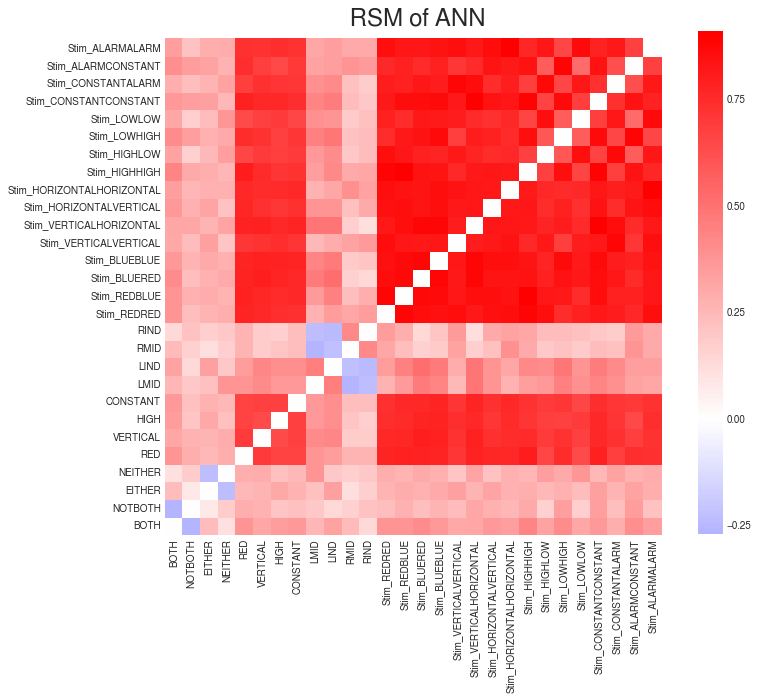

In [163]:
ann_rsm = np.loadtxt(basedir + 'data/results/MODEL/ANN1280_HiddenLayerRSM_NoDynamics.csv')

plt.figure(figsize=(10,10))
plt.title("RSM of ANN",fontsize=24)
ax = sns.heatmap(ann_rsm,center=0,square=True,cmap='bwr',cbar=True,cbar_kws={'fraction':0.045})
ax.invert_yaxis()
plt.xticks(np.arange(0.5,len(tmp2)+1),tmp2,rotation=90);
plt.yticks(np.arange(0.5,len(tmp2)+1),tmp2,rotation=0);

# Construct RSMs for each subject separately

In [164]:
actflow_rsm = np.zeros((len(labels),len(labels),len(subjNums)))
r_vals = []
i = 0
for mat in hidden_activations:
    act = np.real(np.squeeze(np.asarray(mat)))
    mat = np.corrcoef(act)
    np.fill_diagonal(mat,0)
    actflow_rsm[:,:,i] = np.arctanh(mat)
    triu_ind = np.triu_indices(ann_rsm.shape[0],k=1)
    r, p = stats.pearsonr(np.arctanh(np.real(ann_rsm[triu_ind])),mat[triu_ind])
    r_vals.append(r)
    i += 1

In [165]:
print("Correlate individual RSMs, and then average r-values")
print "Averaged r =", np.tanh(np.mean(r_vals))
t, p = stats.ttest_1samp(r_vals,0)
print 'T-test against 0, t =', t, '| p =', p

Correlate individual RSMs, and then average r-values
Averaged r = 0.0949416153532
T-test against 0, t = 8.45217534286 | p = 3.32697176581e-13


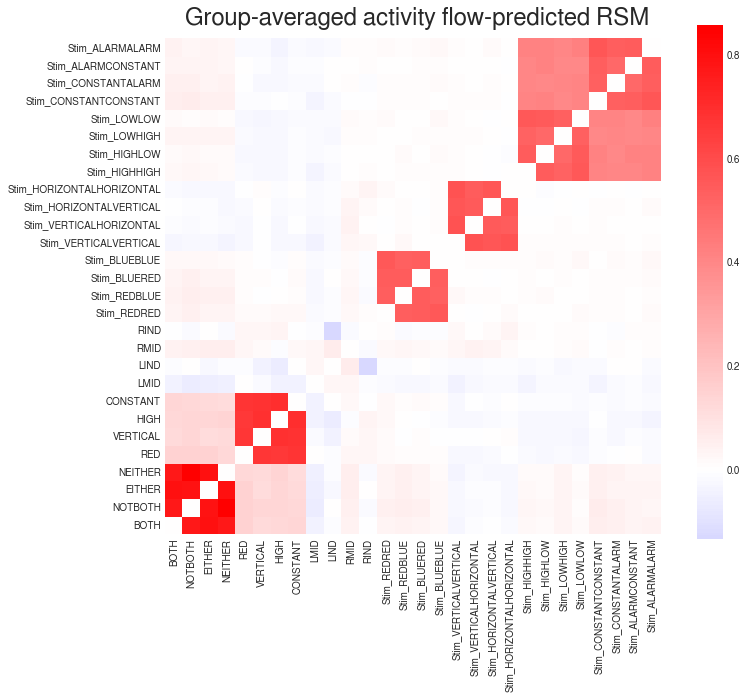

In [166]:
mat = np.mean(actflow_rsm,axis=2)
np.fill_diagonal(mat,0)
plt.figure(figsize=(10,10))
plt.title("Group-averaged activity flow-predicted RSM", fontsize=24)
ax = sns.heatmap(np.tanh(mat),center=0,square=True,cmap='bwr',cbar_kws={'fraction':0.046})
ax.invert_yaxis()
plt.xticks(np.arange(0.5,len(tmp2)+1),tmp2,rotation=90);
plt.yticks(np.arange(0.5,len(tmp2)+1),tmp2,rotation=0);

#### Average all RSMs, and then correlate activity-flow predicted RSMs with ANN RSMs

In [167]:
triu_ind = np.triu_indices(ann_rsm.shape[0],k=1)
r, p = stats.pearsonr(np.arctanh(np.real(ann_rsm[triu_ind])),mat[triu_ind])
print 'r =', r, '| p =', p

r = 0.109190066441 | p = 0.0338196278946


___

#### Load regions with highest similarity to ANN RSM

In [168]:
n_hiddenregions = 10
sourcedir = '/projects3/SRActFlow/data/results/GroupfMRI/RSA/'
hiddenregions = np.loadtxt(sourcedir + 'RSA_Similarity_SortedRegions.txt',delimiter=',')
hiddenregions = hiddenregions[:n_hiddenregions]

#### Run RSA and construct RSM

In [169]:
rsm = np.zeros((n_features, n_features, len(subjNums)))

hidden_ind = []
for roi in hiddenregions:
    roi_ind = np.where(glasser2==roi+1)[0]
    hidden_ind.extend(roi_ind)

hidden_ind = np.asarray(hidden_ind)

for s in range(len(subjNums)):
    tmp = np.corrcoef(data_task[hidden_ind,:,s].T)
    np.fill_diagonal(tmp,0)
    tmp = np.arctanh(tmp)
    rsm[:,:,s] = tmp.copy()
        


#### Plot group-averaged actual empirical RSM

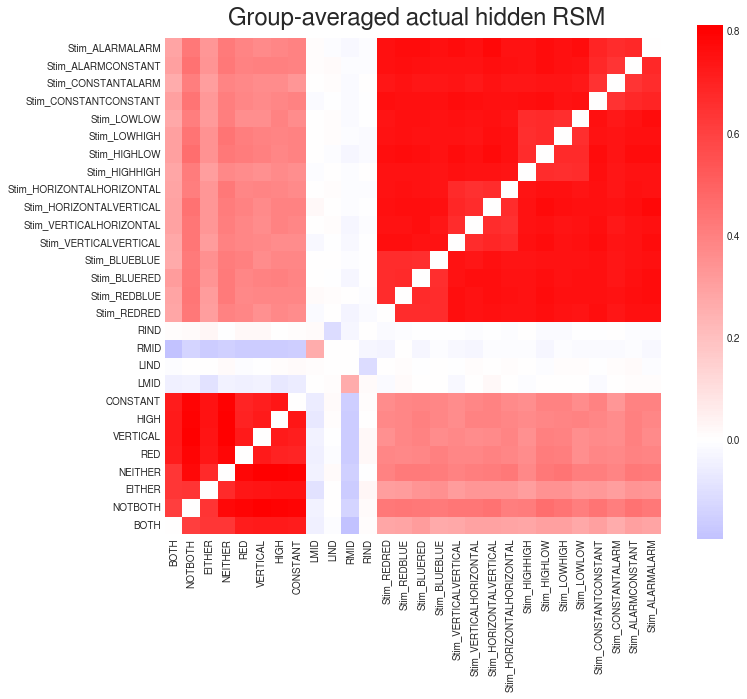

In [170]:
mat = np.mean(rsm,axis=2)
np.fill_diagonal(mat,0)
plt.figure(figsize=(10,10))
plt.title("Group-averaged actual hidden RSM", fontsize=24)
ax = sns.heatmap(np.tanh(mat),center=0,square=True,cmap='bwr',cbar_kws={'fraction':0.046})
ax.invert_yaxis()
plt.xticks(np.arange(0.5,len(tmp2)+1),tmp2,rotation=90);
plt.yticks(np.arange(0.5,len(tmp2)+1),tmp2,rotation=0);

# Now compare actual to predicted RSM, actual to ANN RSM, predicted to ANN RSM

Actual-to-predicted:
	 mean r = 0.432263678672 | t = 30.969486478 | p = 1.93557040431e-51
Actual-to-ANN:
	 mean r = 0.523573959557 | t = 29.3181615971 | p = 2.16540951843e-49
Predicted-to-ANN:
	 mean r = 0.0707717242271 | t = 6.24660692896 | p = 1.17726591758e-08


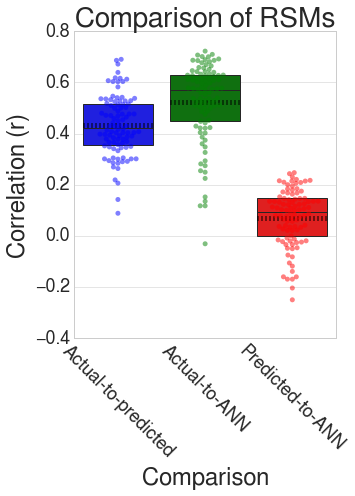

In [171]:

df_compareRSM = {}
df_compareRSM['Comparison'] = []
df_compareRSM['Subject'] = []
df_compareRSM['R'] = []
for s in range(len(subjNums)):
    df_compareRSM['Comparison'].append('Actual-to-predicted')
    df_compareRSM['Subject'].append(subjNums[s])
    df_compareRSM['R'].append(stats.pearsonr(rsm[:,:,s][triu_ind],actflow_rsm[:,:,s][triu_ind])[0])
    
    df_compareRSM['Comparison'].append('Actual-to-ANN')
    df_compareRSM['Subject'].append(subjNums[s])
    df_compareRSM['R'].append(stats.pearsonr(np.arctanh(ann_rsm[triu_ind]),rsm[:,:,s][triu_ind])[0])
    
    df_compareRSM['Comparison'].append('Predicted-to-ANN')
    df_compareRSM['Subject'].append(subjNums[s])
    df_compareRSM['R'].append(stats.pearsonr(np.arctanh(ann_rsm[triu_ind]),actflow_rsm[:,:,s][triu_ind])[0])
    
        
df_compareRSM = pd.DataFrame(df_compareRSM)

# Draw a nested boxplot to show bills by day and time
plt.figure(figsize=(5,7))
actual2predicted = df_compareRSM.loc[df_compareRSM['Comparison']=='Actual-to-predicted']
actual2ANN = df_compareRSM.loc[df_compareRSM['Comparison']=='Actual-to-ANN']
predicted2ANN = df_compareRSM.loc[df_compareRSM['Comparison']=='Predicted-to-ANN']

# t, p = stats.ttest_rel(tmptask['Dimensionality'],tmprest['Dimensionality'])

sns.boxplot(data=[actual2predicted['R'],actual2ANN['R'],predicted2ANN['R']],
           meanline=True,showmeans=True,meanprops={'linewidth':5,'color':'k','linestyle':':'},
           medianprops={'linestyle':'-'},sym='',whis=0)
sns.swarmplot(data=[actual2predicted['R'],actual2ANN['R'],predicted2ANN['R']],
            alpha=0.5)
plt.title('Comparison of RSMs',fontsize=28,fontname='FreeSans')
plt.ylabel('Correlation (r)',fontsize=24)
plt.xlabel('Comparison',fontsize=24)
plt.xticks(np.arange(3),['Actual-to-predicted','Actual-to-ANN','Predicted-to-ANN'],fontname='FreeSans',fontsize=18, rotation=-45)
# plt.ylim([np.min(df_dimensionality['R'])-np.std(df_dimensionality['Dimensionality']),np.max(df_dimensionality['Dimensionality'])+2*np.std(df_dimensionality['Dimensionality'])]);
plt.yticks(fontsize=18)
plt.tight_layout()

## Run t-tests against 0 for each
t, p = stats.ttest_1samp(np.arctanh(actual2predicted['R']),0)
print 'Actual-to-predicted:'
print '\t mean r =', np.mean(actual2predicted['R'].values),'| t =', t, '| p =', p

t, p = stats.ttest_1samp(np.arctanh(actual2ANN['R']),0)
print 'Actual-to-ANN:'
print '\t mean r =', np.mean(actual2ANN['R'].values),'| t =', t, '| p =', p

t, p = stats.ttest_1samp(np.arctanh(predicted2ANN['R']),0)
print 'Predicted-to-ANN:'
print '\t mean r =', np.mean(predicted2ANN['R'].values),'| t =', t, '| p =', p
